# Development: Applying 3-Category Classifier with New Architecture
Utilize already-trained model to classify input data, within the new chips & catalog paradigm.  

Two main modes of application:  
(1) Apply to arbitrary set of catalog data to generate scores;  
(2) Apply to imagery tiles in order to generate comprehensive LULC maps  

Both of these modes will be captured in a single notebook, with the intention that each can be executed independently.  
For starters, notebook will cover (2).
  
Date: 2019-02-11  
Author: Peter Kerins  

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import ogr, gdal
import pandas as pd

from keras.models import load_model
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.layers import Dropout

from keras.models import Model


import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_rasters
import util_vectors
import util_keras
import util_training
from image_sample_generator import ImageSampleGenerator
from tilewise_generator import TilewiseGenerator
import util_imagery
import util_workflow
import util_chips
from batch_generator import BatchGenerator
import util_scoring

Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


## Preparation

### Set key variables

In [2]:
# core
data_root='/data/phase_iv/'
place = 'sitapur'
data_path=data_root+place+'/'

resolution = 5  # Lx:15 S2:10

# tiling
tile_resolution = resolution
tile_size = 256
tile_pad = 32


# misc
s2_bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

### Load and inspect study area

sitapur Sitapur
>>> ogrinfo -al -so /data/phase_iv/sitapur/Sitapur_studyArea.shp
INFO: Open of `/data/phase_iv/sitapur/Sitapur_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Sitapur_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-18
Geometry: Polygon
Feature Count: 1
Extent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iv/sitapur/Sitapur_studyAreaEPSG4326.shp
INFO: Open of `/data/phase_iv/sitapur/Sit

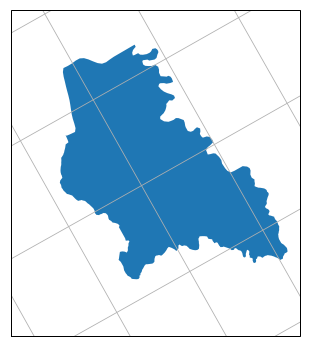

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 587
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[80.54417672689733, 27.654738923241645], [80.56039780033113, 27.6547913102528], [80.56034001206851, 27.669235266940337], [80.54411680645714, 27.669182847947447], [80.54417672689733, 27.654738923241645]]]}


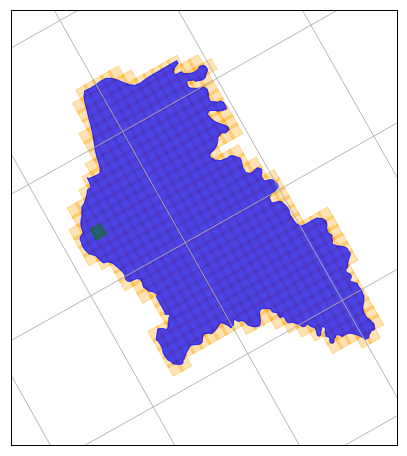

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [5]:
window = 17

# bands stuff outdated! needs to be reconciled with catalog filtering
# will ignore for the moment since this is a bigger fix...
# haven't done any examples yet incorporating additional chips beyond s2
# into construction of a training sample
bands_vir=s2_bands[:-1]
bands_sar=None
bands_ndvi=None
bands_ndbi=None
bands_osm=None

# this can get updated when cloudmasking is added
haze_removal = False

batch_size = 128
balancing = None

# move as appropriate

model_id = '3cat_Sit_gen-test'
unflatten_input = True # is the model a cnn?
n_cats = 3 # number of categories

water_overwrite = False
water_mask = False

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir 6


### Load model
Includes loading custom loss function used during training

In [7]:
category_weights_filename = data_root+'models/'+model_id+'_category_weights.pkl'
category_weights = pickle.load( open( category_weights_filename, "rb" ) )
weights = list(zip(*category_weights.items())[1])

network_filename = data_root+'models/'+model_id+'.hd5'
network = load_model(network_filename, custom_objects={'loss': util_training.make_loss_function_wcc(weights)})
network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 6, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 17, 17)   4832        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 17, 17)   1760        input_2[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 17, 17)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

***

## Apply model: mapping
Apply model to imagery (ie input stack) to classify all pixels in some area, and save the results as images.

### First take using `ImageSampleGenerator`

In [8]:
# imagery
resampling = 'bilinear'
processing_level = None
source = 's2'
image_suffix = 'F'
water_mask = True

In [9]:
if resolution==10: 
    zfill=3
elif resolution==5:
    zfill=4
elif resolution==2:
    zfill=5 

In [10]:


tile_side = tile_size+(2*tile_pad)
blank_tile = np.zeros((tile_side,tile_side),dtype='uint8')
blank_tile.fill(255)

for tile_id in range(len(tiles['features'])):#range(single_tile_id,single_tile_id+1):
    if tile_id % 10 == 0:
        print 'tile',tile_id,'of',len(tiles['features'])
    tilepath = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
        place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
        'tile'+str(tile_id).zfill(zfill)+'.tif'
    im, geo, prj, cols, rows = util_rasters.load_geotiff(tilepath,dtype='uint16')
    generator = ImageSampleGenerator(im,pad=tile_pad,look_window=17,prep_image=True)
    predictions = network.predict_generator(generator, steps=generator.steps, verbose=0,
                  use_multiprocessing=False, max_queue_size=1, workers=1,)
    Yhat = predictions.argmax(axis=-1)
    Yhat_square = Yhat.reshape((tile_size,tile_size),order='F')
    Yhat_tile = blank_tile.copy()
    Yhat_tile[tile_pad:-tile_pad,tile_pad:-tile_pad] = Yhat_square[:,:]
    outpath = data_root+place+'/maps/'+\
        place+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
        'tile'+str(tile_id).zfill(zfill)+'_'+model_id+'_lulc'+'.tif'
    #print outpath
    util_rasters.write_1band_geotiff(outpath, Yhat_tile, geo, prj, data_type=gdal.GDT_Byte)
    
    if water_mask:
        water = util_imagery.calc_water_mask(im[:-1], bands_first=True)
        waterpath = data_root+place+'/maps/'+\
            place+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
            'tile'+str(tile_id).zfill(zfill)+'_'+model_id+'_water'+'.tif'
        util_rasters.write_1band_geotiff(waterpath, water, geo, prj, data_type=gdal.GDT_Byte)

tile 0 of 587
tile 10 of 587
tile 20 of 587
tile 30 of 587
tile 40 of 587
tile 50 of 587
tile 60 of 587
tile 70 of 587
tile 80 of 587
tile 90 of 587
tile 100 of 587
tile 110 of 587
tile 120 of 587
tile 130 of 587
tile 140 of 587
tile 150 of 587
tile 160 of 587
tile 170 of 587
tile 180 of 587
tile 190 of 587
tile 200 of 587
tile 210 of 587
tile 220 of 587
tile 230 of 587
tile 240 of 587
tile 250 of 587
tile 260 of 587
tile 270 of 587
tile 280 of 587
tile 290 of 587
tile 300 of 587
tile 310 of 587
tile 320 of 587
tile 330 of 587
tile 340 of 587
tile 350 of 587
tile 360 of 587
tile 370 of 587
tile 380 of 587
tile 390 of 587
tile 400 of 587
tile 410 of 587
tile 420 of 587
tile 430 of 587
tile 440 of 587
tile 450 of 587
tile 460 of 587
tile 470 of 587
tile 480 of 587
tile 490 of 587
tile 500 of 587
tile 510 of 587
tile 520 of 587
tile 530 of 587
tile 540 of 587
tile 550 of 587
tile 560 of 587
tile 570 of 587
tile 580 of 587


### Second take using `TilewiseGenerator`

In [8]:
# imagery
image_suffix = 'F'
processing = None
source = 's2'

In [9]:
generator = TilewiseGenerator(place,
                             image_suffix,
                             tiles)

In [10]:
image_tile_path = '/data/phase_iv/sitapur/imagery/none/sitapur_s2_F_5m_p32_tile0000.tif'
image, geo, prj, cols, rows = util_rasters.load_geotiff(image_tile_path,dtype='uint16')
print image.shape
print generator._prep_image(image).shape

import tensorflow as tf
#tf.global_variables()
#tf.trainable_variables()

import keras.backend as K
print("DEFAULT:",K.image_data_format())
K.set_image_data_format('channels_first')
print("UPDATED:",K.image_data_format())

(7, 320, 320)
(6, 320, 320)
('DEFAULT:', 'channels_last')
('UPDATED:', 'channels_first')


In [11]:
predictions = network.predict_generator(generator, steps=generator.steps, verbose=1,
                  use_multiprocessing=False, max_queue_size=1, workers=1,)
print len(predictions)

ResourceExhaustedError: OOM when allocating tensor with shape[65536,32,17,17]
	 [[Node: conv2d_14/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_13/Relu, conv2d_14/kernel/read)]]
	 [[Node: activation_20/Softmax/_553 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_239_activation_20/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'conv2d_14/convolution', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-f52c9569c3bd>", line 6, in <module>
    network = load_model(network_filename, custom_objects={'loss': util_training.make_loss_function_wcc(weights)})
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 240, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 314, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/generic_utils.py", line 140, in deserialize_keras_object
    list(custom_objects.items())))
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2500, in from_config
    process_node(layer, node_data)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2457, in process_node
    layer(input_tensors[0], **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 3195, in conv2d
    data_format=tf_data_format)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[65536,32,17,17]
	 [[Node: conv2d_14/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_13/Relu, conv2d_14/kernel/read)]]
	 [[Node: activation_20/Softmax/_553 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_239_activation_20/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


### Combine model-generated tiles into mosaic
Optional step to create single, city-wide raster

In [11]:
qmarks = '?????'[0:zfill]

path_template = data_root+place+'/maps/'+\
        place+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
        'tile'+qmarks+'_'+model_id+'_lulc'+'.tif'
path_destination = data_root+place+'/maps/'+\
        place+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
        'complete'+'_'+model_id+'_lulc'+'.tif'
!gdal_merge.py -n 255 -a_nodata 255 -o {path_destination} {path_template}

if water_mask:
    water_template = data_root+place+'/maps/'+\
            place+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
            'tile'+qmarks+'_'+model_id+'_water'+'.tif'
    water_destination = data_root+place+'/maps/'+\
            place+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(tile_pad)+'_'+\
            'complete'+'_'+model_id+'_water'+'.tif'
    !gdal_merge.py -n 255 -a_nodata 255 -o {water_destination} {water_template}
    

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Crop mosaic to study area
Optional step to trim mosaic image to match study area (must create mosaic first)

In [12]:
util_rasters.crop_maps(place_shapefile, [path_destination])
if water_mask:
    util_rasters.crop_maps(place_shapefile, [water_destination])

>>> gdalwarp -q -cutline /data/phase_iv/sitapur/Sitapur_studyAreaEPSG4326.shp -of GTiff /data/phase_iv/sitapur/maps/sitapur_F_5m_p32_complete_3cat_Sit_gen-test_lulc.tif /data/phase_iv/sitapur/maps/sitapur_F_5m_p32_complete_3cat_Sit_gen-test_lulc_cut.tif


RuntimeError: command '['gdalwarp', '-q', '-cutline', '/data/phase_iv/sitapur/Sitapur_studyAreaEPSG4326.shp', '-of', 'GTiff', '/data/phase_iv/sitapur/maps/sitapur_F_5m_p32_complete_3cat_Sit_gen-test_lulc.tif', '/data/phase_iv/sitapur/maps/sitapur_F_5m_p32_complete_3cat_Sit_gen-test_lulc_cut.tif']' return with error (code 1): 

***

## Apply model: score results
Apply model to some set of chips and compare its predictions to the actual LULC values

In [ ]:
place_images = {}
place_images['sitapur'] = ['F']

label_suffix = 'aue'
label_lot = '0'
source = 's2'
resolution = int(tile_resolution)
resampling = 'bilinear'
processing_level = None

look_window = 17
batch_size = 128

notes = 'application of 3cat_Hyd_P-U'

### Specify data of interest
Load and manipulate the catalog to specify which samples are to be used

In [ ]:
df = util_chips.load_catalog()
print len(df.index)

In [ ]:
mask = pd.Series(data=np.zeros(len(df.index),dtype='uint8'), index=range(len(df)), dtype='uint8')

for place,image_list in place_images.iteritems():
    for image in image_list:
        mask |= (df['city']==place) & (df['image']==image)

# straight away remove road samples
mask &= (df['lulc']!=6)

# filter others according to specifications
mask &= (df['gt_type']==label_suffix)
mask &= (df['gt_lot']==int(label_lot))
mask &= (df['source']==source)
mask &= (df['resolution']==int(resolution))
mask &= (df['resampling']==resampling)
mask &= (df['processing']==str(processing_level).lower())

print np.sum(mask)

#### Filter by locale
Optional step: filter catalog to include only samples from validation locales. This is appropriate only if model is being applied to data from a city that provided training samples. In other cities, every pixel is "out of sample".

In [ ]:
place_locales_filename = data_root+'models/'+model_id+'_place_locales.pkl'
with open(place_locales_filename, "rb") as f:
    place_locales = pickle.load(f)

mask &= (df['locale'].isin(place_locales[place][1]))

#### Apply mask to create final list of samples

In [ ]:
#here for example we will just exclude all roads samples
df = df[mask]
df.reset_index(drop=True,inplace=True)
len(df)

### Create generator for serving samples

In [ ]:
generator = BatchGenerator(df,remapping='3cat',look_window=window,batch_size=batch_size,one_hot=3)

### Apply model to selected samples

In [ ]:
generator.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions = network.predict_generator(generator, steps=generator.steps, verbose=1,
                  use_multiprocessing=True, max_queue_size=40, workers=64,)
print predictions.shape

In [ ]:
Yhat = predictions.argmax(axis=-1)
print Yhat.shape

### Extract corresponding _actual_ ground-truth values directly from catalog

In [ ]:
Y = generator.get_label_series().values
print Y.shape

### Generate typical scoring information

In [ ]:
print "evaluate training"
# hardcoded categories
categories=[0,1,2]
confusion = util_scoring.calc_confusion(Yhat,Y,categories)
recalls, precisions, accuracy = util_scoring.calc_confusion_details(confusion)

# Calculate f-score
beta = 2
f_score = (beta**2 + 1) * precisions * recalls / ( (beta**2 * precisions) + recalls )
f_score_open = f_score[0] 
f_score_nonres = f_score[1]  
f_score_res = f_score[2]  
f_score_roads = None#f_score[3]  
f_score_average = np.mean(f_score)

In [ ]:
# expanding lists to match expected model_record stuff
recalls_expanded = [recalls[0],recalls[1],recalls[2],None]
precisions_expanded = [precisions[0],precisions[1],precisions[2],None]

### Record application and results

In [ ]:
reload(util_scoring)
util_scoring.record_model_application(
        model_id, notes, place_images, label_suffix, resolution, stack_label, feature_count, 
        generator.look_window, generator.remapping, 
        confusion, recalls_expanded, precisions_expanded, accuracy,
        f_score_open, f_score_nonres, f_score_res, f_score_roads, f_score_average)